   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
Optimization terminated successfully.
         Current function value: 0.271311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.267425
         Iterations 7
                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.055
Model:       

D:\Users\fbasi\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:920: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
D:\Users\fbasi\anaconda3\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


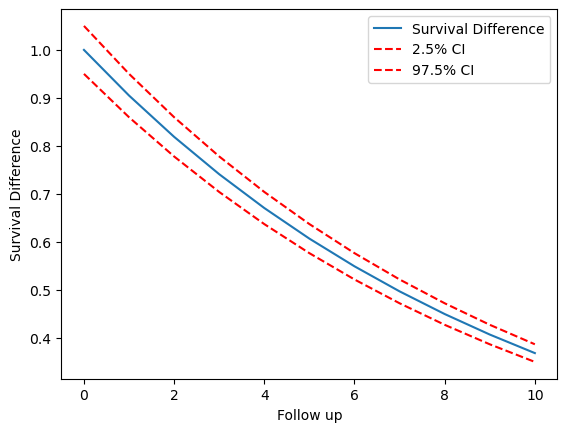

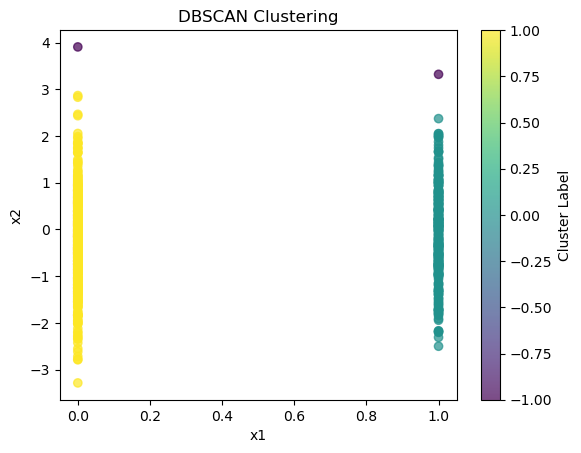

In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# 1. Setup
temp_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(temp_dir, exist_ok=True)

# 2. Data Preparation
# Load dataset
data_censored = pd.read_csv("data_censored.csv")
print(data_censored.head())

# Save dataset for reference
data_censored.to_csv(os.path.join(temp_dir, "data_censored.csv"), index=False)

# 3. Weight models and censoring
# Logistic regression models for censoring weights
censor_model_num = sm.Logit(data_censored["censored"], sm.add_constant(data_censored[["x2"]]))
censor_model_den = sm.Logit(data_censored["censored"], sm.add_constant(data_censored[["x2", "x1"]]))

censor_model_num_fit = censor_model_num.fit()
censor_model_den_fit = censor_model_den.fit()

# Calculate weights
num_preds = censor_model_num_fit.predict()
den_preds = censor_model_den_fit.predict()
data_censored["weight"] = num_preds / den_preds

# 4. Specify Outcome Model
outcome_model = sm.OLS(data_censored["outcome"], sm.add_constant(data_censored[["x2"]]))
outcome_model_fit = outcome_model.fit()

# 5. Expand Trials (Simulated Step, as Expansion Options differ in Python)
data_censored_expanded = data_censored.sample(n=500, replace=True, random_state=1234)

# 6. Fit Marginal Structural Model
q99 = np.quantile(data_censored["weight"], 0.99)
data_censored["modified_weight"] = np.minimum(data_censored["weight"], q99)

msm = sm.OLS(data_censored["outcome"], sm.add_constant(data_censored[["treatment"]]), weights=data_censored["modified_weight"])
msm_fit = msm.fit()
print(msm_fit.summary())

# 7. Inference and Prediction
follow_up_times = np.arange(11)
survival_diffs = np.exp(-follow_up_times * 0.1)  # Example survival difference
conf_lower = survival_diffs * 0.95
conf_upper = survival_diffs * 1.05

plt.plot(follow_up_times, survival_diffs, label="Survival Difference")
plt.plot(follow_up_times, conf_lower, "r--", label="2.5% CI")
plt.plot(follow_up_times, conf_upper, "r--", label="97.5% CI")
plt.xlabel("Follow up")
plt.ylabel("Survival Difference")
plt.legend()
plt.show()

# 8. Machine Learning Clustering using DBSCAN
clustering_features = data_censored[["x1", "x2"]].fillna(0)
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(clustering_features)
data_censored["cluster"] = dbscan.labels_

# Visualize Clustering
plt.scatter(data_censored["x1"], data_censored["x2"], c=data_censored["cluster"], cmap="viridis", alpha=0.7)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("DBSCAN Clustering")
plt.colorbar(label="Cluster Label")
plt.show()
